In [59]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Extract ZIP file

In [60]:
#!unzip '/content/drive/MyDrive/SWE_428_data/CNN_dataset.zip'

# Importing Libs

In [61]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, AvgPool2D
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# Take images

In [62]:
dir = '/content/drive/MyDrive/SWE_428_data/CNN_dataset/'
images = []
disease_names = []
class_names = [ 'CXR', 'AbdomenCT','ChestCT', 'Hand', 'HeadCT']


In [63]:
for i, class_name in enumerate(class_names):
  class_path = os.path.join(dir, class_name)
  for img_name in os.listdir(class_path):
      img_path = os.path.join(class_path, img_name)
      img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
      img = cv2.resize(img, (64, 64))
      images.append(img)
      disease_names.append(i)

In [64]:
images = np.array(images, dtype=np.float32)
images = np.expand_dims(images, axis=-1)
disease_names = np.array(disease_names, dtype=np.int32)

# Seperate Train and Test Dataset

In [65]:
x_train, x_test, y_train, y_test = train_test_split(
    images, disease_names, test_size=0.15, stratify=disease_names, random_state=69)

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.1/(0.75-0.1),
    stratify=y_train, random_state=69)

In [66]:
x_train /= 255.
x_val /= 255.
x_test /= 255.

# Creating CNN MODEL

In [67]:
model = tf.keras.Sequential()
model.add(Conv2D(filters=64, kernel_size=(2,2),strides=(1, 1), padding='same', activation='relu', input_shape=(64,64,1))) 
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Conv2D(filters=32, kernel_size=(2,2),strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Conv2D(filters=64, kernel_size=(2,2),strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 64, 64, 64)        320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        8224      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 16, 16, 32)       

In [68]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [69]:
#Reshaping for CNN 
x_train = x_train.reshape(-1,64, 64,1) 
x_test = x_test.reshape(-1,64, 64, 1)
x_train.shape

(11555, 64, 64, 1)

In [70]:
model_log=model.fit(x_train, y_train,
          batch_size=64,
          epochs=10,
          verbose=1,
          validation_split=.20)

Epoch 1/10
145/145 [==============================] - 4s 17ms/step - loss: 0.0681 - accuracy: 0.9797 - val_loss: 0.0375 - val_accuracy: 0.9987
Epoch 2/10
145/145 [==============================] - 2s 14ms/step - loss: 0.0099 - accuracy: 0.9988 - val_loss: 0.0263 - val_accuracy: 1.0000
Epoch 3/10
145/145 [==============================] - 2s 14ms/step - loss: 0.0016 - accuracy: 0.9997 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 4/10
145/145 [==============================] - 2s 16ms/step - loss: 3.0826e-04 - accuracy: 0.9999 - val_loss: 6.5067e-04 - val_accuracy: 1.0000
Epoch 5/10
145/145 [==============================] - 2s 16ms/step - loss: 5.1962e-04 - accuracy: 0.9999 - val_loss: 9.7400e-04 - val_accuracy: 1.0000
Epoch 6/10
145/145 [==============================] - 2s 14ms/step - loss: 6.0264e-04 - accuracy: 0.9999 - val_loss: 4.7529e-04 - val_accuracy: 1.0000
Epoch 7/10
145/145 [==============================] - 2s 14ms/step - loss: 1.2824e-04 - accuracy: 1.0000 - val_loss: 2

In [71]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Accuracy:', score[1])
predictions = model.predict(x_test)
predictions[0]
np.argmax(predictions[0])

Accuracy: 1.0
76/76 [==============================] - 0s 3ms/step


2

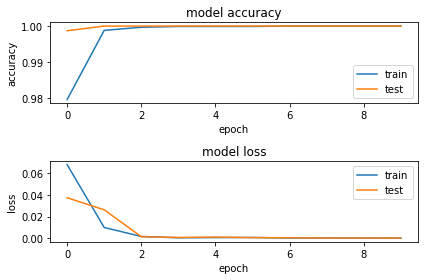

In [72]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(model_log.history['accuracy'])
plt.plot(model_log.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.subplot(2,1,2)
plt.plot(model_log.history['loss'])
plt.plot(model_log.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()